In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import sup_defs

In [2]:
import importlib
importlib.reload(sup_defs)

<module 'sup_defs' from 'C:\\Users\\Friedrich\\Jupyter_Projects\\marketing_campaign\\sup_defs.py'>

In [3]:
marketing_campaign = pd.read_csv('marketing_campaign.csv', sep='\t')
marketing_campaign

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


There are not enough values in the Income column, it is best to delete them

In [4]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

I think it would be better to group 'PhD', 'Master' and 'Basic', '2n Cycle'

In [5]:
marketing_campaign['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

And this is divided into those who are together and those who are alone

In [6]:
marketing_campaign['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

There are few NA values, they can simply be removed

In [7]:
marketing_campaign = marketing_campaign.dropna().reset_index(drop=True)

One good indicator would be the average unit price of a product. Such an indicator will contain two columns, which will reduce the sample size. Also, indicators of the number of purchases made and the money spent on them are important in themselves. They will allow you to identify buyers who make purchases of a cheaper or more expensive product.

In [8]:
# Most likely, the dataset was assembled a long time ago, but we will not tell anyone
today_date = dt.date(2020,1,30)

# I would like to know how many days customers use our services
marketing_campaign['Dt_Customer'] = pd.to_datetime(marketing_campaign['Dt_Customer'])
marketing_campaign['customer_days'] = pd.to_datetime(today_date) - marketing_campaign['Dt_Customer']
marketing_campaign['customer_days'] = marketing_campaign['customer_days'].dt.days

# Calculating customer's age
marketing_campaign['customer_age'] = today_date.year - marketing_campaign['Year_Birth']

# The amount of purchases will make it easier to divide customers into groups
marketing_campaign['total_spent'] = marketing_campaign['MntWines'] + \
                                    marketing_campaign['MntFruits'] + \
                                    marketing_campaign['MntMeatProducts'] + \
                                    marketing_campaign['MntFishProducts'] + \
                                    marketing_campaign['MntSweetProducts'] + \
                                    marketing_campaign['MntGoldProds']

marketing_campaign['total_purchases'] = marketing_campaign['NumWebPurchases'] + \
                                        marketing_campaign['NumCatalogPurchases'] + \
                                        marketing_campaign['NumStorePurchases'] 

marketing_campaign['mean_goods_price'] = marketing_campaign['total_spent'] / marketing_campaign['total_purchases']

# It is worth determining how successful campaigns are in general
marketing_campaign['total_accepted_cmp'] = marketing_campaign['AcceptedCmp1'] + \
                                           marketing_campaign['AcceptedCmp2'] + \
                                           marketing_campaign['AcceptedCmp3'] + \
                                           marketing_campaign['AcceptedCmp4'] + \
                                           marketing_campaign['AcceptedCmp5'] + \
                                           marketing_campaign['Response']

for i in range(1,6):
    marketing_campaign['AcceptedCmp%s' % i] = marketing_campaign['AcceptedCmp%s' % i].replace({0:'Not accepted',
                                                                                             1:'Accepted'})

marketing_campaign['Response'] = marketing_campaign['Response'].replace({0:'Not accepted',
                                                                         1:'Accepted'})

# Children are children
marketing_campaign['total_childrens'] = marketing_campaign['Kidhome'] + marketing_campaign['Teenhome']

marketing_campaign['single_together'] = marketing_campaign['Marital_Status'].replace({'Single':1,
                                                                                      'Divorced':1,
                                                                                      'Widow':1,
                                                                                      'Alone':1,
                                                                                      'Absurd':1, 
                                                                                      'YOLO':1, 
                                                                                      'Together':2, 
                                                                                      'Married':2})

marketing_campaign['family_size'] = marketing_campaign['single_together'] + marketing_campaign['total_childrens']

marketing_campaign['parent'] = marketing_campaign['total_childrens'].map(lambda x: 0 if x == 0 else 1)

marketing_campaign['graduate'] = marketing_campaign['Education'].replace({'2n Cycle':0,
                                                                          'Basic':0,
                                                                          'Graduation':1,
                                                                          'Master':2,
                                                                          'PhD':2})

need_drop_1 = ['Year_Birth', 'Marital_Status', 'Kidhome', 'Teenhome', 'Dt_Customer', 
               'Z_CostContact', 'Z_Revenue',  'Complain', 'Recency']

marketing_campaign = marketing_campaign.drop(need_drop_1, axis=1)

Now we need to check the data for possible outliers

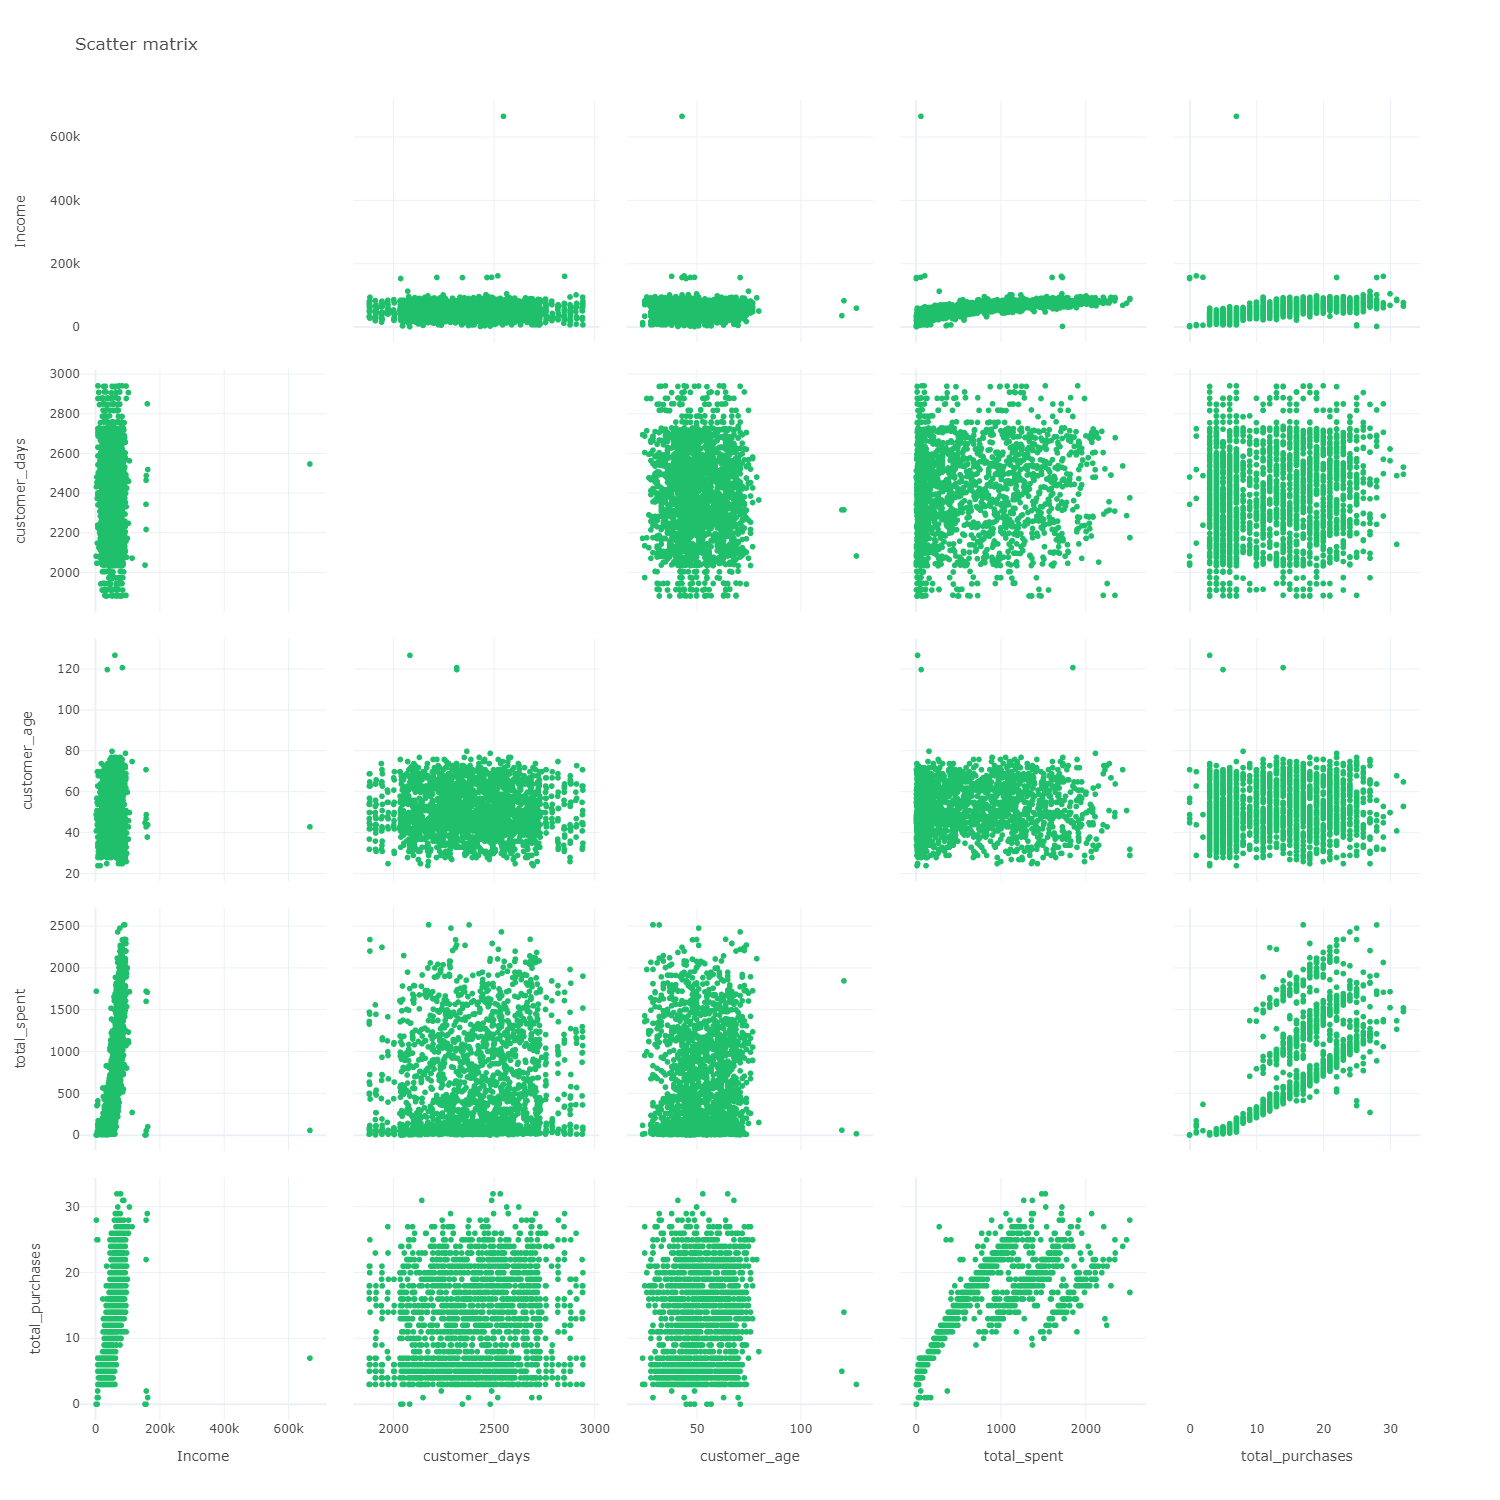

In [9]:
cols = ['Income', 'customer_days', 'customer_age', 'total_spent', 'total_purchases']
sup_defs.scatmat_plot(dataf=marketing_campaign, 
                      dimensions=cols, 
                      color=None, 
                      title='Scatter matrix').show('png')

In [10]:
marketing_campaign.describe()

,ID,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,single_together,family_size,parent,graduate
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,52247.251354,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,...,51.179603,607.075361,12.557310,inf,0.448556,0.947202,1.645307,2.592509,0.714350,1.267148
std,3249.376275,25173.076661,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,...,11.985554,602.900476,7.204611,NaN,0.892440,0.749062,0.478528,0.905722,0.451825,0.652084
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.000000,5.000000,0.000000,2.666667,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2814.750000,35303.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,43.000000,69.000000,6.000000,13.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000
50%,5458.500000,51381.500000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,...,50.000000,396.500000,12.000000,29.966667,0.000000,1.000000,2.000000,3.000000,1.000000,1.000000
75%,8421.750000,68522.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,...,61.000000,1048.000000,18.000000,50.250000,1.000000,1.000000,2.000000,3.000000,1.000000,2.000000
max,11191.000000,666666.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,...,127.000000,2525.000000,32.000000,inf,5.000000,3.000000,2.000000,5.000000,1.000000,2.000000


Who are these people?

In [11]:
marketing_campaign[marketing_campaign['mean_goods_price'] > 10**9]

,ID,Education,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,single_together,family_size,parent,graduate
642,5555,Graduation,153924.0,1,1,1,1,1,1,0,...,45,6,0,inf,0,0,1,1,0,1
968,3955,Graduation,4861.0,2,1,1,1,0,1,0,...,55,6,0,inf,0,0,1,1,0,1
1232,6862,Graduation,1730.0,1,1,3,1,1,1,15,...,49,8,0,inf,0,0,1,1,0,1
1507,11110,Graduation,3502.0,2,1,1,0,0,1,0,...,47,5,0,inf,0,1,1,2,1,1
1829,9931,PhD,4023.0,5,0,1,1,1,1,15,...,57,9,0,inf,0,2,2,4,1,2
2109,11181,PhD,156924.0,2,1,2,1,1,1,0,...,71,8,0,inf,0,0,2,2,0,2


The income and age of some clients is abnormally high. There are several such clients, the easiest way is to simply ignore them.

Customers with an infinite average price of a product look just as suspicious. They bought very cheap goods from nowhere, and some even at a discount. They are also best ignored.

In [12]:
marketing_campaign = marketing_campaign[(marketing_campaign['Income'] < 500000) & \
                                        (marketing_campaign['customer_age'] < 100) & \
                                        (marketing_campaign['mean_goods_price'] < 10**9)
                                        ].reset_index(drop=True)

It is worth removing the columns that have little effect on sales and the columns for the success of promotional campaigns, since we need to determine which groups to pay more attention to, and not which groups they are.

In [13]:
need_drop_2 = ['ID', 'Education', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'total_accepted_cmp', 'single_together']

marketing_campaign_fstd = marketing_campaign.drop(need_drop_2, axis=1)

In [14]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2206 non-null   int64  
 1   Education            2206 non-null   object 
 2   Income               2206 non-null   float64
 3   MntWines             2206 non-null   int64  
 4   MntFruits            2206 non-null   int64  
 5   MntMeatProducts      2206 non-null   int64  
 6   MntFishProducts      2206 non-null   int64  
 7   MntSweetProducts     2206 non-null   int64  
 8   MntGoldProds         2206 non-null   int64  
 9   NumDealsPurchases    2206 non-null   int64  
 10  NumWebPurchases      2206 non-null   int64  
 11  NumCatalogPurchases  2206 non-null   int64  
 12  NumStorePurchases    2206 non-null   int64  
 13  NumWebVisitsMonth    2206 non-null   int64  
 14  AcceptedCmp3         2206 non-null   object 
 15  AcceptedCmp4         2206 non-null   o

Apparently the most traded goods are wine and meat (unexpectedly).
Other interesting features:

    - Parents buy less meat.
    - People with high income prefer to buy goods through the catalog and rarely visit the site.
    - Meat products prefer to buy through the catalog.
    - The price of purchased wine depends on income.

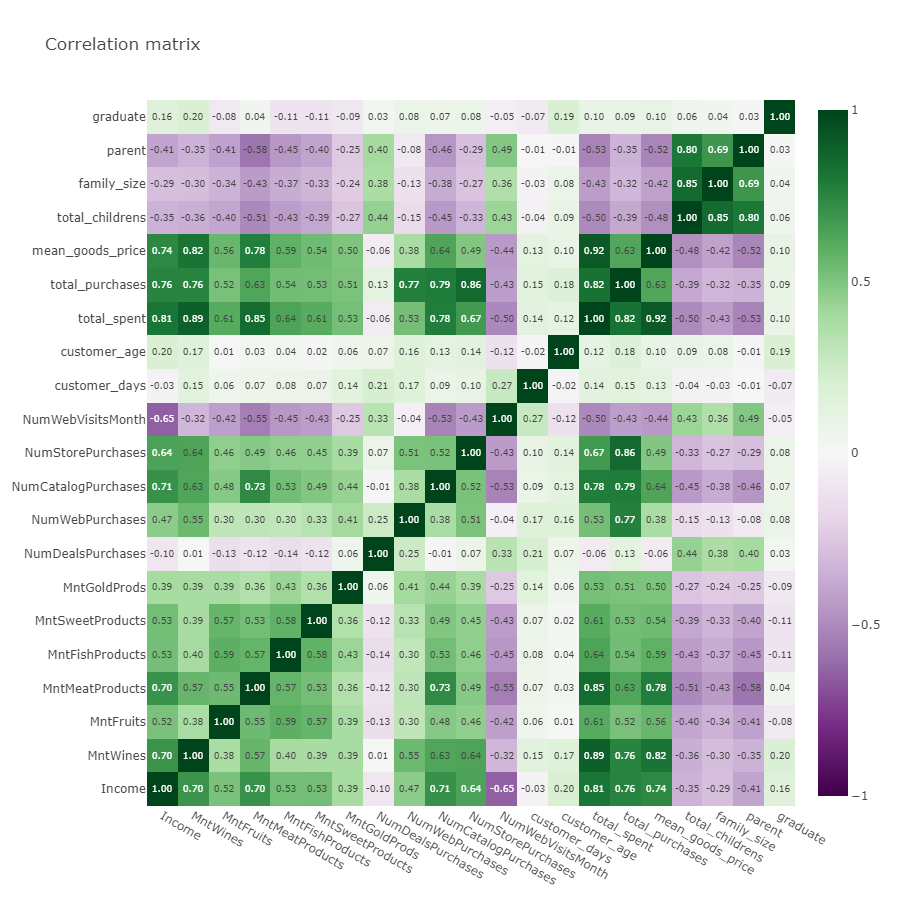

In [15]:
corr = marketing_campaign_fstd.corr()
sup_defs.corr_plot(x=corr.index.values, 
                   y=corr.columns.values, 
                   z=corr.values, 
                   title='Correlation matrix').show('png')

In [16]:
marketing_campaign_fstd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2206 non-null   float64
 1   MntWines             2206 non-null   int64  
 2   MntFruits            2206 non-null   int64  
 3   MntMeatProducts      2206 non-null   int64  
 4   MntFishProducts      2206 non-null   int64  
 5   MntSweetProducts     2206 non-null   int64  
 6   MntGoldProds         2206 non-null   int64  
 7   NumDealsPurchases    2206 non-null   int64  
 8   NumWebPurchases      2206 non-null   int64  
 9   NumCatalogPurchases  2206 non-null   int64  
 10  NumStorePurchases    2206 non-null   int64  
 11  NumWebVisitsMonth    2206 non-null   int64  
 12  customer_days        2206 non-null   int64  
 13  customer_age         2206 non-null   int64  
 14  total_spent          2206 non-null   int64  
 15  total_purchases      2206 non-null   i

In this issue, I can not compete with the ML library:

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [17]:
std_scaler = StandardScaler()
std_scaler.fit(marketing_campaign_fstd)
marketing_campaign_scal = pd.DataFrame(std_scaler.transform(marketing_campaign_fstd), columns=marketing_campaign_fstd.columns )
marketing_campaign_scal

,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,NumWebVisitsMonth,customer_days,customer_age,total_spent,total_purchases,mean_goods_price,total_childrens,family_size,parent,graduate
0,0.291407,0.974963,1.549059,1.687245,2.449823,1.480786,0.849960,0.361994,1.425194,2.500566,...,0.714759,1.972244,1.018496,1.673525,1.308371,1.195941,-1.266906,-1.763261,-1.585162,-0.411142
1,-0.264252,-0.874837,-0.638697,-0.719794,-0.652347,-0.635259,-0.735592,-0.168258,-1.132371,-0.573695,...,-0.128878,-1.668745,1.274795,-0.966002,-1.197311,-1.024683,1.403705,0.447454,0.630850,-0.411142
2,0.926264,0.355399,0.568341,-0.180439,1.336691,-0.148812,-0.039496,-0.698509,1.425194,-0.232110,...,-0.550697,-0.175337,0.335032,0.277398,1.029962,0.041549,-1.266906,-0.657903,-1.585162,-0.411142
3,-1.192298,-0.874837,-0.563257,-0.657389,-0.506363,-0.586614,-0.754928,-0.168258,-0.767004,-0.915279,...,0.292940,-1.926971,-1.288195,-0.922840,-0.918902,-0.955376,0.068400,0.447454,0.630850,-0.411142
4,0.298709,-0.394600,0.417461,-0.220556,0.150567,-0.002878,-0.561568,1.422497,0.329095,0.109474,...,-0.128878,-0.825206,-1.031896,-0.310270,0.194735,-0.246455,0.068400,0.447454,0.630850,1.123510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,0.436752,1.194331,0.417461,0.064722,0.077575,2.210456,3.924386,-0.168258,1.790560,0.109474,...,-0.128878,0.121623,0.164166,1.215343,0.473144,1.539015,0.068400,0.447454,0.630850,-0.411142
2202,0.568247,0.296110,-0.663843,-0.612815,-0.688844,-0.659581,-0.696920,2.483000,1.425194,-0.232110,...,0.714759,-1.944186,1.958260,-0.273748,0.333940,-0.264515,2.739011,2.658170,0.630850,1.123510
2203,0.236896,1.784251,0.543194,0.220734,-0.104906,-0.367713,-0.387544,-0.698509,-0.767004,0.109474,...,0.292940,-0.851028,-1.031896,1.049335,0.751553,1.044388,-1.266906,-1.763261,-1.585162,-0.411142
2204,0.814698,0.361328,0.090555,0.207362,0.771001,0.070089,0.327888,-0.168258,0.694461,0.792643,...,-0.972515,-0.846725,1.103929,0.388623,1.169167,0.086223,0.068400,0.447454,0.630850,1.123510


Many columns correlate with each other, so it will be better to combine them

In [18]:
marketing_size = len(marketing_campaign_scal.columns)
pca = PCA(n_components=marketing_size)
pca_fit = pca.fit(marketing_campaign_scal)
PC_values = np.arange(marketing_size) + 1

var_ratio = pca.explained_variance_ratio_
pca_colnames = ['PCA_%s' % i for i in PC_values]

marketing_pca_df = pd.DataFrame(pca.transform(marketing_campaign_scal), 
                                columns=(pca_colnames), 
                                index=marketing_campaign_scal.index)

In [19]:
fpca = 0
perc = np.zeros(shape=marketing_size)
for i in range(marketing_size):
    fpca += var_ratio[i] * 100
    perc[i] = fpca

Now we need to determine how much information is enough for us. I think 80% will be just right.

In [20]:
var_ratio_df = pd.DataFrame([var_ratio, perc], columns=pca_colnames)
var_ratio_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21
0,0.438268,0.121129,0.071034,0.056342,0.041763,0.040131,0.032410,0.031252,0.027912,0.025989,...,0.019395,0.018820,0.014523,0.013068,0.011260,0.008008,0.005477,0.002234,1.052063e-32,9.671356e-34
1,43.826767,55.939635,63.043001,68.677195,72.853459,76.866516,80.107467,83.232687,86.023880,88.622809,...,92.660997,94.542958,95.995282,97.302062,98.428091,99.228897,99.776563,100.000000,1.000000e+02,1.000000e+02


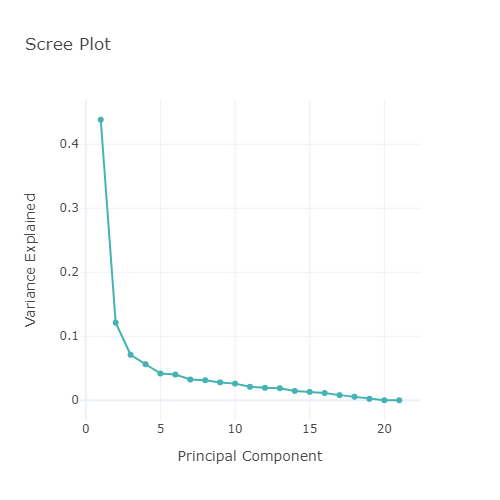

In [21]:
sup_defs.scree_plot(x=PC_values, 
                    y=var_ratio).show('png')

Selecting the necessary components in the dataset

In [22]:
marketing_80_df = marketing_pca_df.drop(['PCA_%s' % i for i in range(8,22)], axis=1)
marketing_80_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,5.095900,0.017541,2.264328,-0.968364,-0.622247,1.969284,-0.179603
1,-3.127482,-0.457968,-1.743100,1.235162,-0.686565,0.520862,0.588436
2,2.456121,-0.697624,0.082492,-0.265002,-1.565250,-0.971849,-0.724627
3,-2.998929,-1.203136,-0.315213,0.885938,0.506055,-1.506884,0.277141
4,-0.384960,0.868662,-0.503063,0.448059,0.996769,-1.135479,-0.588670
...,...,...,...,...,...,...,...
2201,2.755913,1.644970,1.323133,1.000658,-0.517226,0.205449,2.394196
2202,-1.878735,4.287946,-2.620787,0.923852,-0.338204,-0.096317,0.428126
2203,2.611063,-1.567538,0.077216,-1.284884,0.440679,-1.612545,-0.083035
2204,1.794893,1.284767,-1.852947,0.518298,-0.700828,-0.458642,-0.268177


Now we need to determine the required number of clusters. For this I use Elbow method.

The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

I think the KMeans algorithm will be enough for this task.

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

In [23]:
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(marketing_80_df)
    distortions.append(kmeanModel.inertia_)

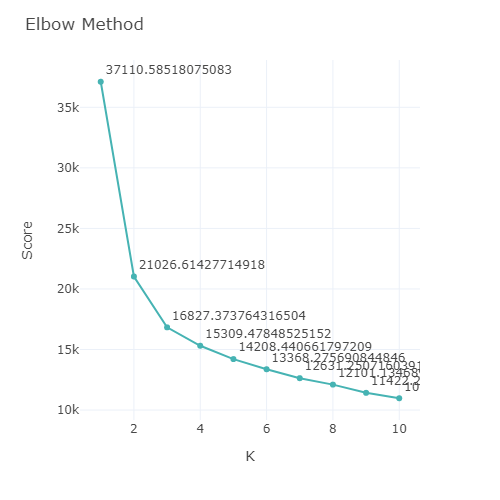

In [24]:
sup_defs.line_plot(x=K, 
                   y=distortions,
                   title='Elbow Method',
                   xaxis_title='K', 
                   yaxis_title='Score').show('png')

Four clusters will be enough

In [25]:
AC = KMeans(n_clusters=4)

AC_clust = AC.fit_predict(marketing_80_df)
marketing_80_df['Clusters'] = AC_clust
marketing_80_df['Clusters'] = marketing_80_df['Clusters'].replace({0:'Group_1',
                                                                   1:'Group_2',
                                                                   2:'Group_3',
                                                                   3:'Group_4'})
#Adding the Clusters feature to the orignal dataframe.
marketing_campaign['Clusters'] = AC_clust
marketing_campaign['Clusters'] = marketing_campaign['Clusters'].replace({0:'Group_1',
                                                                         1:'Group_2',
                                                                         2:'Group_3',
                                                                         3:'Group_4'})
marketing_campaign = marketing_campaign.sort_values('Clusters')

marketing_campaign['single_together'] = marketing_campaign['single_together'].replace({1:'Single',
                                                                                       2:'Together'})

marketing_campaign['graduate'] = marketing_campaign['graduate'].replace({0:'Basic',
                                                                         1:'Graduation',
                                                                         2:'Master'})

colors = ['#20bf6b', '#fa8231', '#3867d6', '#eb3b5a']
cluster_names = ['Group_1', 'Group_2', 'Group_3', 'Group_4']
cluster_colors = {'Group_1':'#20bf6b', 'Group_2':'#fa8231', 'Group_3':'#3867d6', 'Group_4':'#eb3b5a'}

The algorithm split the data into 4 almost identical clusters. Now we need to evaluate our groups.

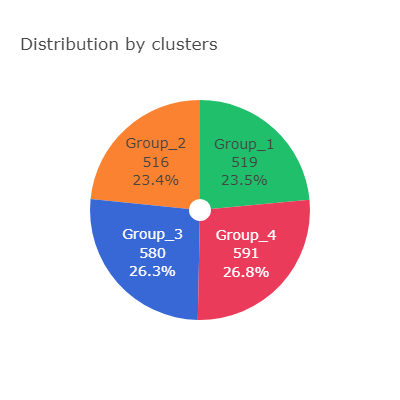

In [26]:
cluster_count = marketing_campaign['Clusters'].value_counts().sort_index()
sup_defs.pie_plot(labels=cluster_count.index,
                  values=cluster_count.values,
                  title='Distribution by clusters').show('png')

The dependence of money spent in the store on income clearly shows the division of customers into clusters. The graph shows the usual relationship between these indicators, but group 1 is of some interest. The income of this group is higher than that of group 3, but the average amount of purchased goods is approximately equal. This group should be given more attention, most likely the company does not provide the goods necessary for this group or promotional companies do not take this group into account.

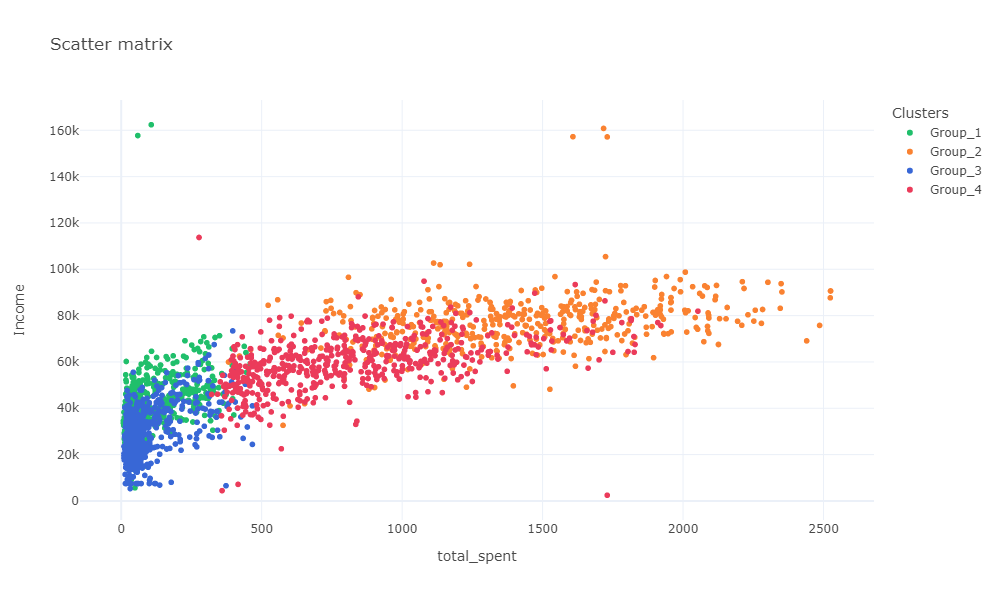

In [27]:
sup_defs.scat_plot(dataf=marketing_campaign,
                   x='total_spent',
                   y='Income',
                   color='Clusters',
                   title='Scatter matrix').show('png')

The dependence of the number of purchases on their price indicates the difference between groups 2 and 4. Group 2 buys more expensive goods

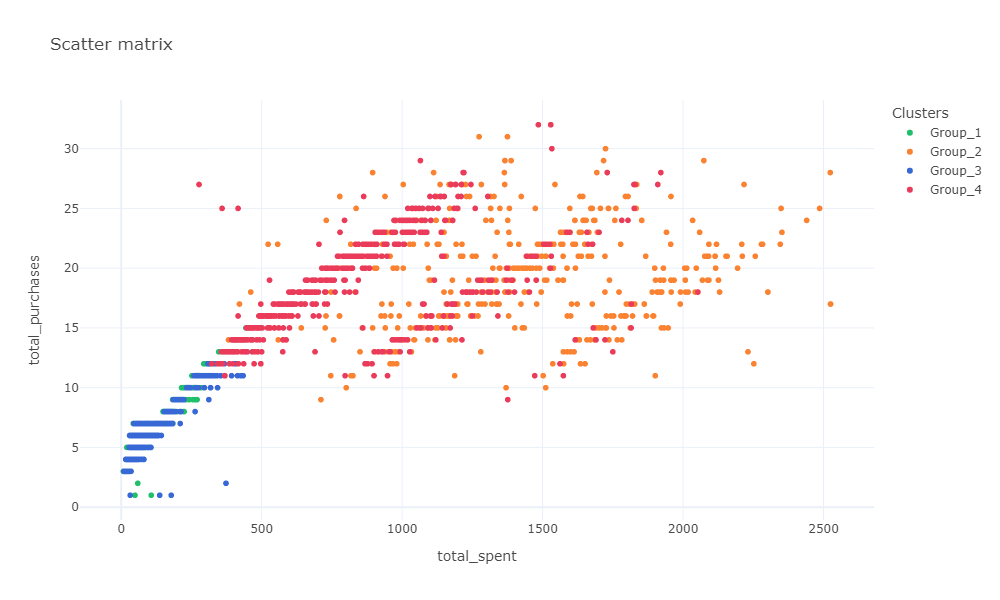

In [28]:
sup_defs.scat_plot(dataf=marketing_campaign,
                   x='total_spent',
                   y='total_purchases',
                   color='Clusters',
                   title='Scatter matrix').show('png')

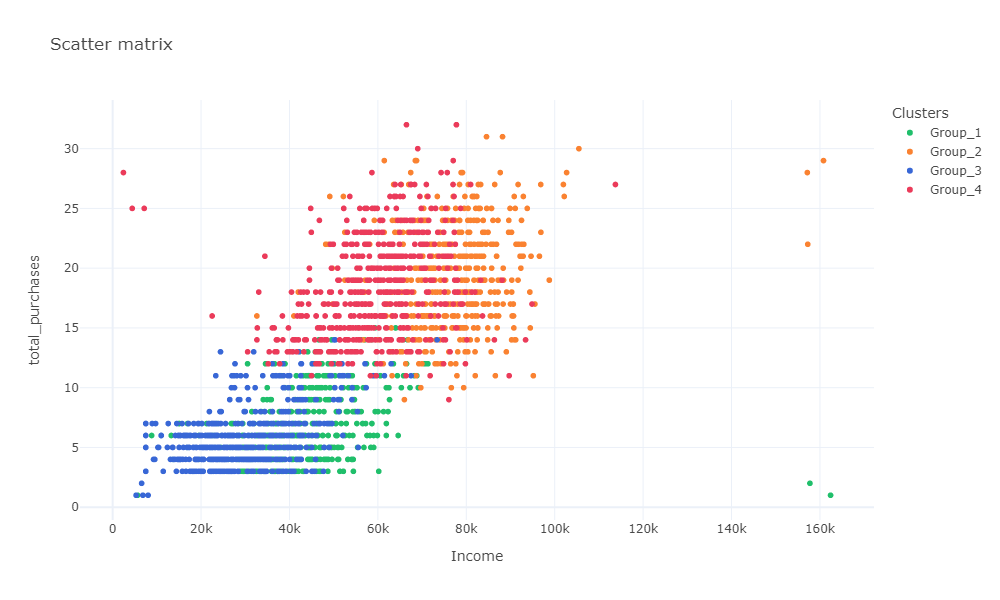

In [29]:
sup_defs.scat_plot(dataf=marketing_campaign,
                   x='Income',
                   y='total_purchases',
                   color='Clusters',
                   title='Scatter matrix').show('png')

The age of clients does not differ much, but it is noticeable that the group with the lowest income is the youngest.

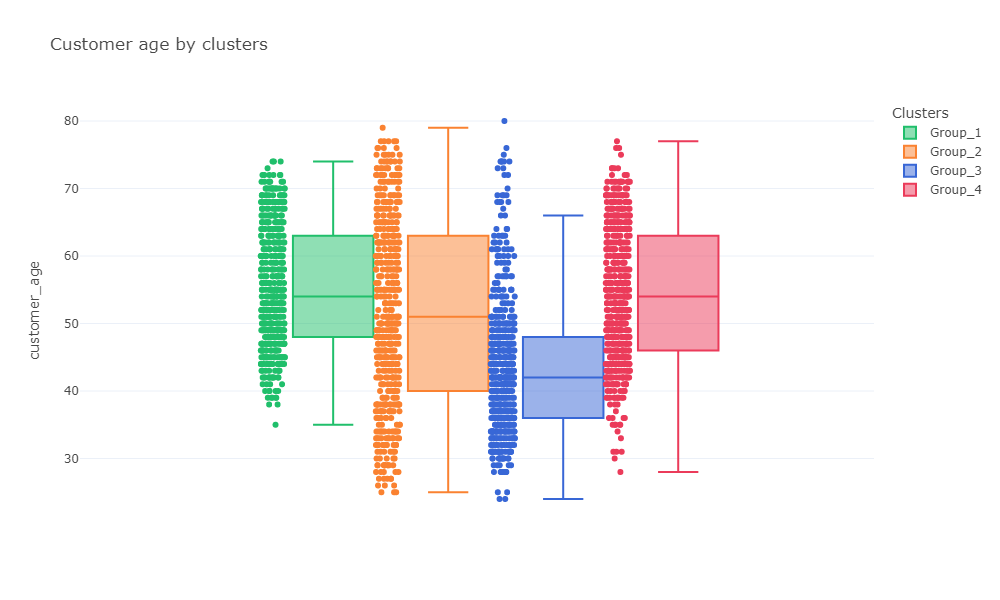

In [30]:
sup_defs.box_plot(dataf=marketing_campaign,
                  y='customer_age',
                  color='Clusters',
                  title='Customer age by clusters').show('png')

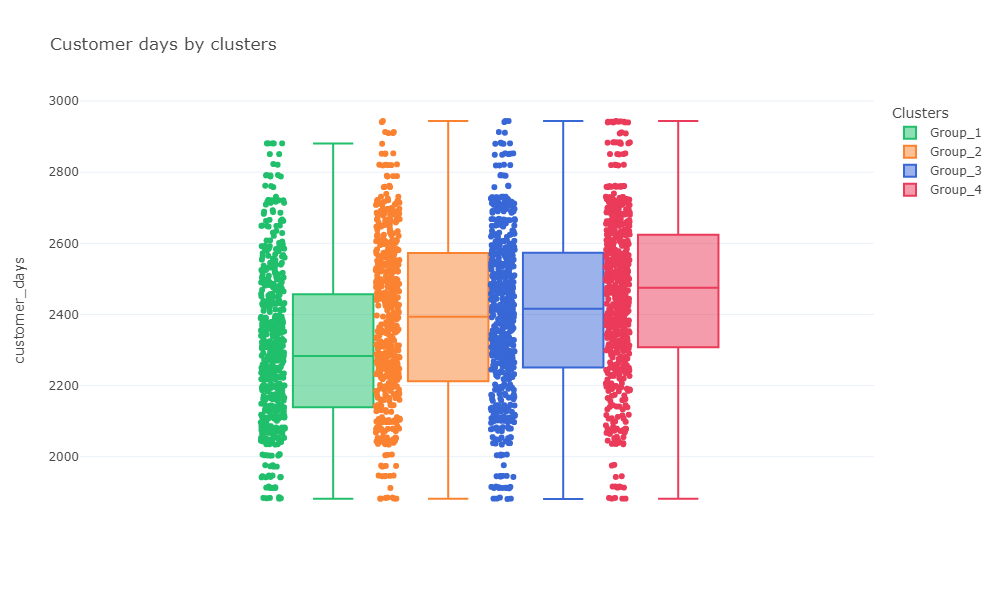

In [31]:
sup_defs.box_plot(dataf=marketing_campaign,
                  y='customer_days',
                  color='Clusters',
                  title='Customer days by clusters').show('png')

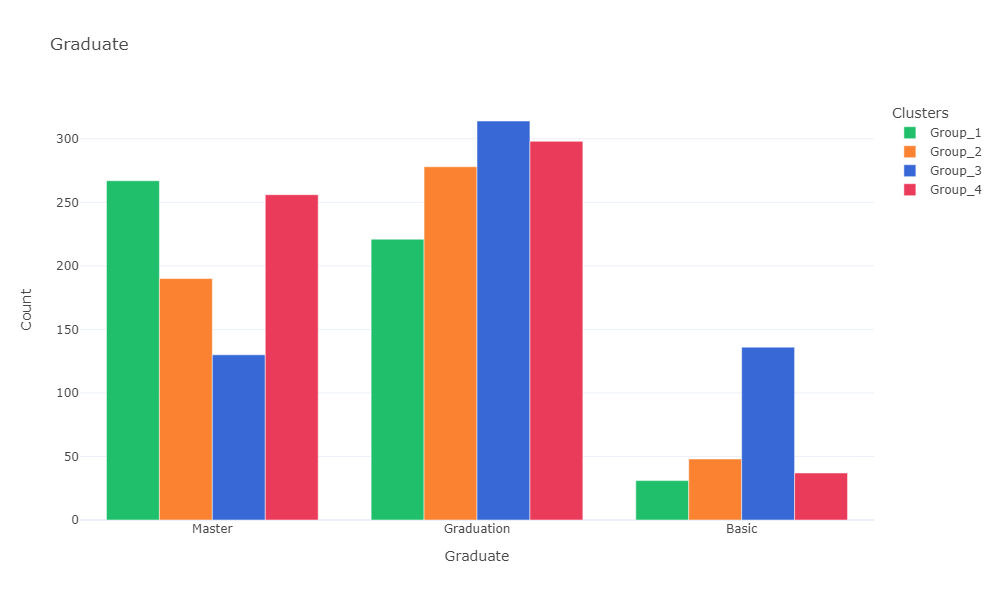

In [32]:
gr_bar_df = marketing_campaign.value_counts(['graduate', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
gr_bar_df['Clusters'] = gr_bar_df['Clusters'].astype(str)

sup_defs.bar_plot(dataf=gr_bar_df,
                  x='graduate',
                  y=0,
                  color='Clusters',
                  title='Graduate',
                  x_label='Graduate',
                  y_label='Count').show('png')

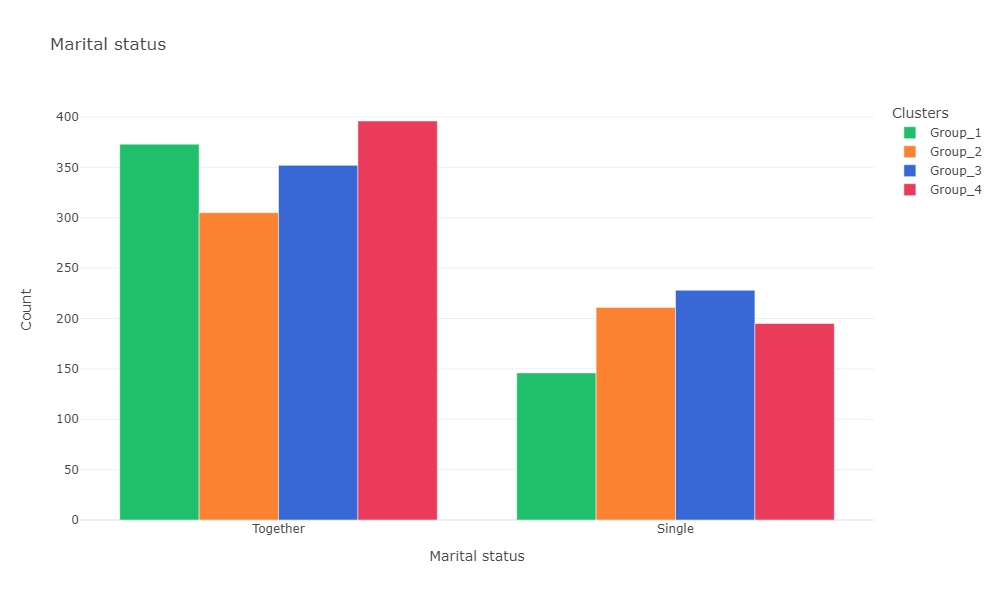

In [33]:
st_bar_df = marketing_campaign.value_counts(['single_together', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
st_bar_df['Clusters'] = st_bar_df['Clusters'].astype(str)

sup_defs.bar_plot(dataf=st_bar_df,
                  x='single_together',
                  y=0,
                  color='Clusters',
                  title='Marital status',
                  x_label='Marital status',
                  y_label='Count').show('png')

Returning to group 1, we can assume that the company provides few products for families with children, so you can consider options for expanding the range to attract this group.

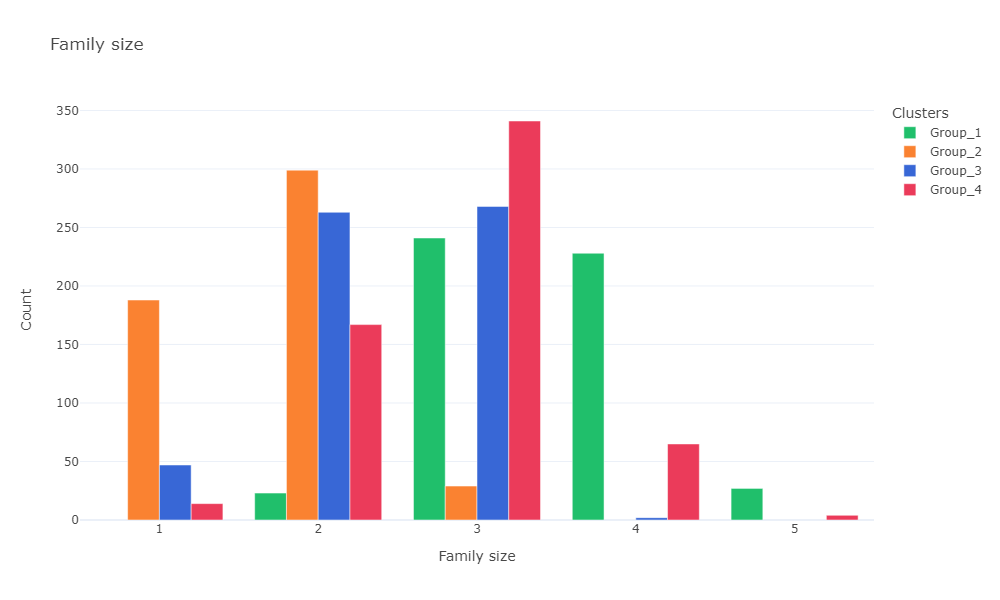

In [34]:
fs_bar_df = marketing_campaign.value_counts(['family_size', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
fs_bar_df['Clusters'] = fs_bar_df['Clusters'].astype(str)

sup_defs.bar_plot(dataf=fs_bar_df,
                  x='family_size',
                  y=0,
                  color='Clusters',
                  title='Family size',
                  x_label='Family size',
                  y_label='Count').show('png')

The most traded commodity is wine. The distribution of clusters for all products is approximately the same, but you can pay attention to meat products. The main consumer of these products is the group with the highest income. Most likely, the price of meat products is higher than in other stores.

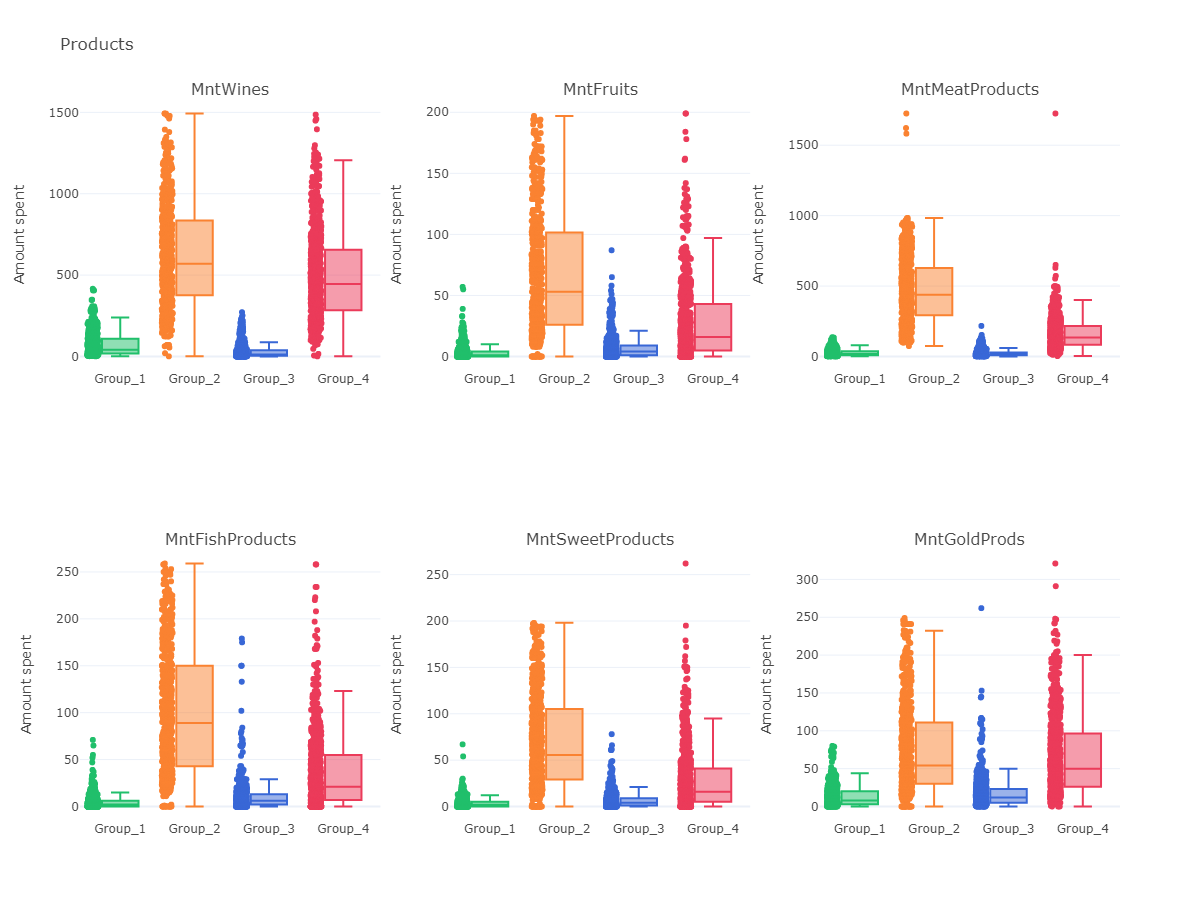

In [35]:
cluster_pars = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds']
box_pos_r = [1, 1, 1, 2, 2, 2]
box_pos_c = [1, 2, 3, 1, 2, 3]
cluster_names = marketing_campaign['Clusters'].unique()
fig_box = make_subplots(rows=2, cols=3, subplot_titles=cluster_pars)

for c_p, b_p_r, b_p_c in zip(cluster_pars, box_pos_r, box_pos_c):
    for c_n, c_c in zip(cluster_names, colors):
        m_c_c = marketing_campaign[marketing_campaign['Clusters'] == c_n]
        fig_box.add_trace(go.Box(x=m_c_c['Clusters'], 
                                 y=m_c_c[c_p],
                                 marker_color=c_c,
                                 boxpoints='all'), 
                          col=b_p_c, 
                          row=b_p_r)
        
        fig_box.update_yaxes(title='Amount spent', col=b_p_c, row=b_p_r)

fig_box.update_layout(height = 900,
                      width=1200,
                      title='Products',
                      font_color='#484848',
                      template='plotly_white',
                      showlegend=False,)
fig_box.show('png')

It is noteworthy that the group with the highest income is the least likely to buy goods at a discount and visit the site the least often. It may be worth considering options to increase the attention of this audience to the site.

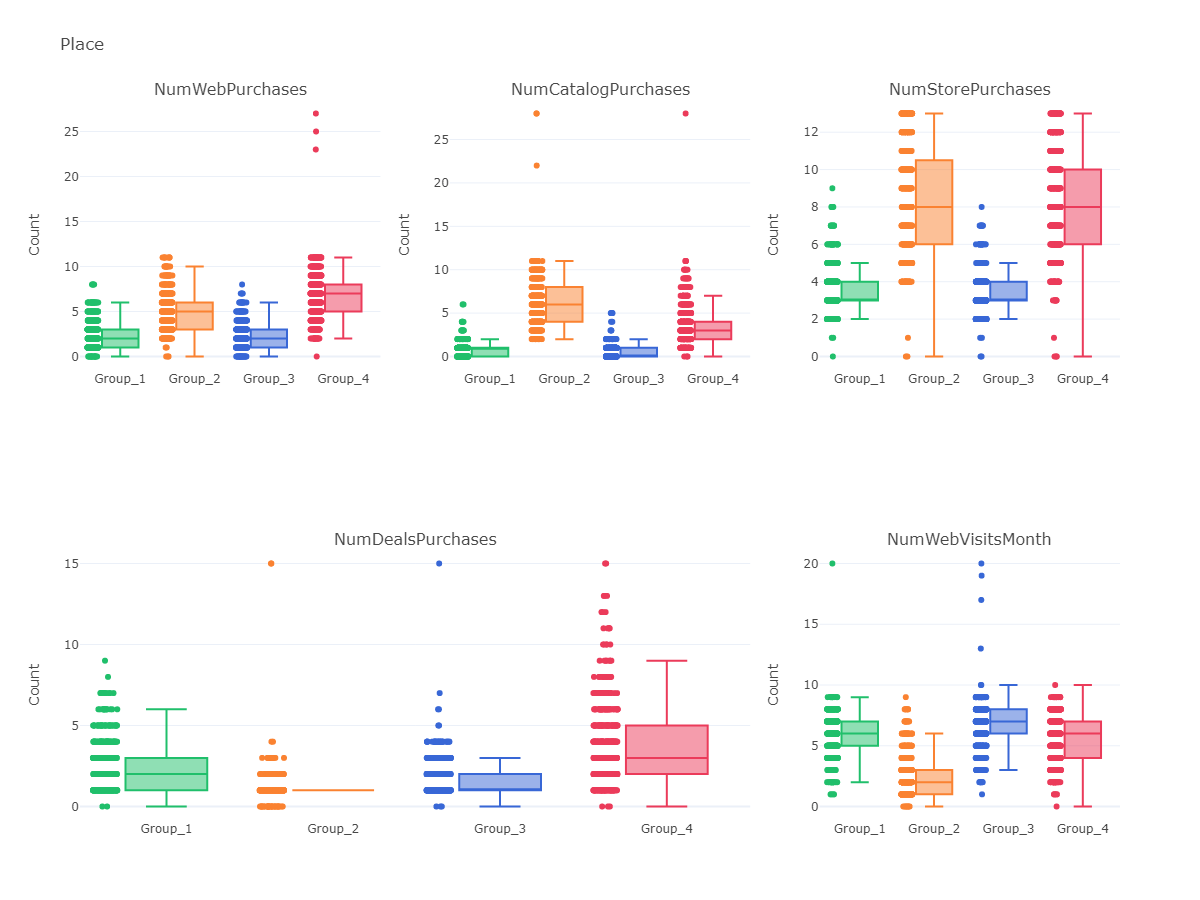

In [36]:
cluster_nums = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']
num_pos_r = [1, 1, 1, 2, 2]
num_pos_c = [1, 2, 3, 1, 3]
cluster_names = marketing_campaign['Clusters'].unique()
fig_num = make_subplots(rows=2, cols=3, subplot_titles=cluster_nums, 
                        specs=[[{}, {}, {}], 
                               [{"colspan": 2}, None, {"colspan":1}]])

for c_ns, n_p_r, n_p_c in zip(cluster_nums, num_pos_r, num_pos_c):
    for c_n, c_c in zip(cluster_names, colors):
        m_c_c = marketing_campaign[marketing_campaign['Clusters'] == c_n]
        fig_num.add_trace(go.Box(x=m_c_c['Clusters'], 
                                 y=m_c_c[c_ns],
                                 marker_color=c_c,
                                 boxpoints='all'), 
                          col=n_p_c, 
                          row=n_p_r)
        
        fig_num.update_yaxes(title='Count', col=n_p_c, row=n_p_r)

fig_num.update_layout(height = 900,
                      width=1200,
                      title='Place',
                      font_color='#484848',
                      template='plotly_white',
                      showlegend=False, )
fig_num.show('png')

The group with the highest income (Group 2) shows the greatest interest in campaigns. Most likely, these campaigns are created with an eye on these customers.

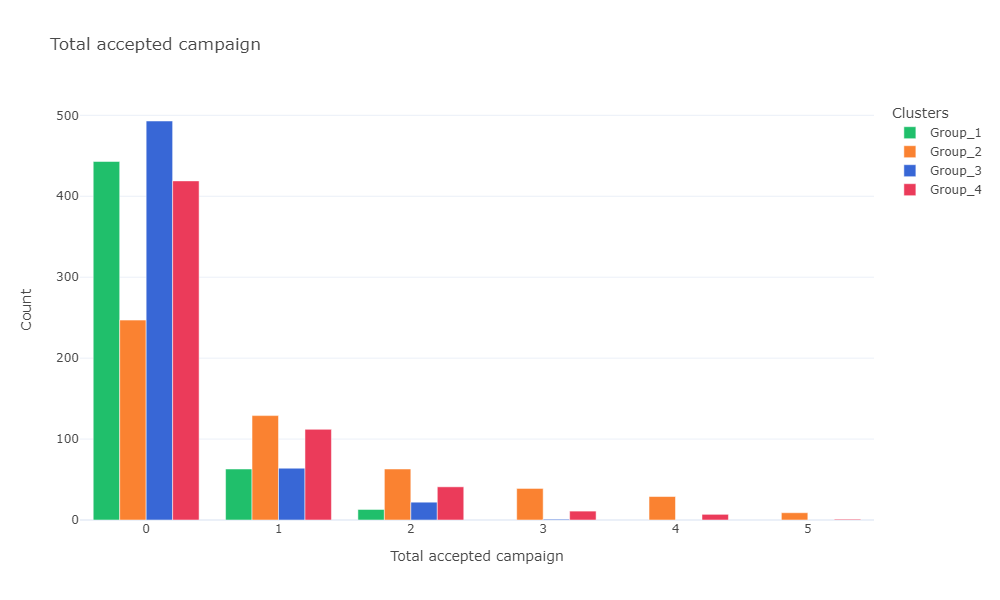

In [37]:
tc_bar_df = marketing_campaign.value_counts(['total_accepted_cmp', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
tc_bar_df['Clusters'] = tc_bar_df['Clusters'].astype(str)

sup_defs.bar_plot(dataf=tc_bar_df,
                  x='total_accepted_cmp',
                  y=0,
                  color='Clusters',
                  title='Total accepted campaign',
                  x_label='Total accepted campaign',
                  y_label='Count').show('png')

I think we can conclude that the last campaign was the most successful and attracted a record number of customers. It seems to me that campaigns should focus not only on group 2, but also on group 4. This group is distinguished by lower income, having one child in the family and interest in discounts, but it is just as loyal as group 2.

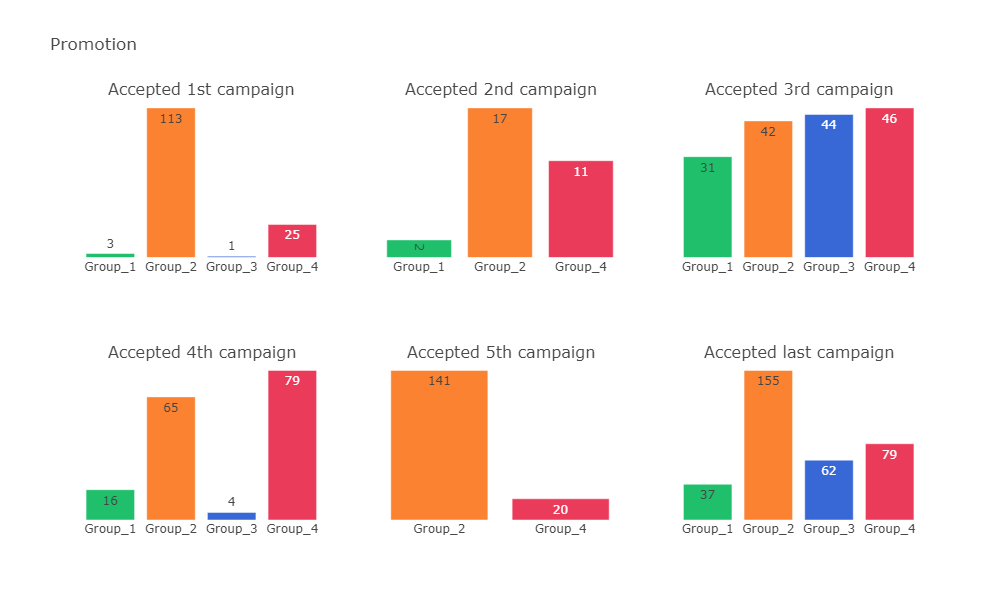

In [38]:
bar_titles = ('Accepted 1st campaign', 'Accepted 2nd campaign', 'Accepted 3rd campaign', 
              'Accepted 4th campaign', 'Accepted 5th campaign', 'Accepted last campaign')
bar_x = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
bar_pos_r = [1, 1, 1, 2, 2, 2]
bar_pos_c = [1, 2, 3, 1, 2, 3]
fig_bar = make_subplots(rows=2, cols=3, subplot_titles=bar_titles)

for b_x, b_p_r, b_p_c, b_t in zip(bar_x, bar_pos_r, bar_pos_c, bar_titles):
    mark_calc = marketing_campaign[marketing_campaign[b_x] == 'Accepted']['Clusters'].value_counts().sort_index()
    for c_n, m_i, m_v in zip(cluster_names, mark_calc.index, mark_calc.values):
        fig_bar.add_trace(go.Bar(x=[m_i], 
                                 y=[m_v],
                                 text=str(m_v),
                                 marker_color=cluster_colors[m_i]), 
                          col=b_p_c, 
                          row=b_p_r
                         )
        fig_bar.update_yaxes(visible=False, col=b_p_c, row=b_p_r)

fig_bar.update_layout(height = 600,
                      width=1000,
                      title='Promotion',
                      font_color='#484848',
                      template='plotly_white',
                      showlegend=False,
                      )
fig_bar.show('png')

In [39]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_1'].describe()

,ID,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,customer_days,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,family_size,parent
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,...,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.0
mean,5551.855491,42527.092486,74.468208,3.678227,27.102119,5.211946,3.720617,13.712909,2.576108,2.454721,...,6.017341,2309.098266,55.308285,127.894027,6.799615,16.053958,0.171484,1.780347,3.499037,1.0
std,3278.068433,13277.808290,77.111127,6.419875,26.087231,8.468963,6.130261,14.667369,1.565028,1.519936,...,1.806703,217.546569,8.910611,108.632009,2.984244,8.734755,0.438799,0.587777,0.665982,0.0
min,9.000000,5648.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1882.000000,35.000000,8.000000,1.000000,2.666667,0.000000,1.000000,2.000000,1.0
25%,2658.500000,34951.000000,19.000000,0.000000,9.000000,0.000000,0.000000,3.000000,1.000000,1.000000,...,5.000000,2139.000000,48.000000,44.000000,4.000000,9.000000,0.000000,1.000000,3.000000,1.0
50%,5493.000000,42033.000000,41.000000,1.000000,17.000000,2.000000,2.000000,8.000000,2.000000,2.000000,...,6.000000,2283.000000,54.000000,81.000000,6.000000,14.500000,0.000000,2.000000,3.000000,1.0
75%,8310.000000,49173.500000,109.500000,4.000000,37.000000,6.000000,5.000000,20.000000,3.000000,3.000000,...,7.000000,2456.000000,63.000000,205.000000,9.000000,23.050000,0.000000,2.000000,4.000000,1.0
max,11188.000000,162397.000000,416.000000,57.000000,137.000000,71.000000,67.000000,80.000000,9.000000,8.000000,...,20.000000,2881.000000,74.000000,459.000000,15.000000,107.000000,2.000000,3.000000,5.000000,1.0


In [40]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_2'].describe()

,ID,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,customer_days,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,family_size,parent
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,5703.329457,76820.050388,620.238372,67.356589,474.155039,99.844961,69.936047,76.075581,1.133721,4.959302,...,2.643411,2391.767442,51.680233,1407.606589,19.368217,75.279924,1.032946,0.100775,1.691860,0.098837
std,3197.755128,11689.243022,319.952726,50.932821,243.526533,66.060984,52.099548,60.822135,1.010405,2.078155,...,1.677022,233.555058,13.704243,416.261422,4.113921,25.754461,1.300067,0.307700,0.571161,0.298733
min,0.000000,32632.000000,1.000000,0.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1882.000000,25.000000,382.000000,9.000000,23.772727,0.000000,0.000000,1.000000,0.000000
25%,3002.500000,70419.000000,376.750000,26.000000,292.750000,43.000000,29.000000,30.000000,1.000000,3.000000,...,1.000000,2214.000000,40.000000,1102.750000,16.000000,58.613487,0.000000,0.000000,1.000000,0.000000
50%,5544.500000,77009.500000,570.500000,53.000000,438.000000,89.000000,55.500000,54.000000,1.000000,5.000000,...,2.000000,2393.500000,51.000000,1379.500000,19.000000,71.736842,1.000000,0.000000,2.000000,0.000000
75%,8539.000000,82572.250000,835.250000,101.250000,626.500000,150.000000,105.000000,111.000000,1.000000,6.000000,...,3.000000,2573.000000,63.000000,1682.750000,22.000000,88.905844,2.000000,0.000000,2.000000,0.000000
max,11101.000000,160803.000000,1493.000000,197.000000,1725.000000,259.000000,198.000000,249.000000,15.000000,11.000000,...,9.000000,2944.000000,79.000000,2525.000000,31.000000,187.666667,5.000000,2.000000,3.000000,1.000000


In [41]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_3'].describe()

,ID,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,customer_days,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,family_size,parent
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,...,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,5532.748276,30069.879310,32.594828,7.289655,24.932759,11.143103,7.272414,18.625862,1.744828,2.162069,...,6.703448,2406.553448,43.467241,101.858621,5.908621,15.166226,0.191379,0.781034,2.387931,0.768966
std,3238.364100,11183.780143,46.661938,10.253719,27.577818,18.946936,10.091375,23.384590,1.121492,1.357360,...,1.879346,228.317301,9.979113,97.942692,2.519752,13.393311,0.491301,0.442148,0.638050,0.421858
min,20.000000,5305.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1881.000000,24.000000,10.000000,1.000000,3.333333,0.000000,0.000000,1.000000,0.000000
25%,2814.750000,22411.750000,5.000000,1.000000,8.000000,2.000000,1.000000,5.000000,1.000000,1.000000,...,6.000000,2251.000000,36.000000,37.000000,4.000000,8.600000,0.000000,1.000000,2.000000,1.000000
50%,5310.000000,29513.000000,13.000000,4.000000,15.000000,6.000000,4.000000,12.000000,1.000000,2.000000,...,7.000000,2416.000000,42.000000,65.000000,5.000000,12.450000,0.000000,1.000000,2.000000,1.000000
75%,8322.750000,37702.000000,38.000000,9.000000,29.000000,13.000000,9.000000,23.000000,2.000000,3.000000,...,8.000000,2573.250000,48.000000,125.500000,7.000000,19.571429,0.000000,1.000000,3.000000,1.000000
max,11191.000000,73395.000000,272.000000,87.000000,217.000000,179.000000,78.000000,262.000000,15.000000,8.000000,...,20.000000,2944.000000,80.000000,467.000000,14.000000,186.500000,3.000000,2.000000,4.000000,1.000000


In [42]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_4'].describe()

,ID,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,customer_days,customer_age,total_spent,total_purchases,mean_goods_price,total_accepted_cmp,total_childrens,family_size,parent
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,...,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,5537.152284,59994.395939,503.698816,29.345178,162.893401,38.216582,29.758037,67.653130,3.685279,6.693739,...,5.632826,2457.218274,54.307953,831.565144,18.355330,45.456530,0.439932,1.123519,2.793570,0.950931
std,3272.354020,11539.448265,287.418051,34.930769,124.442052,44.768865,36.591988,56.087339,2.354031,2.635342,...,1.885414,225.914544,9.871887,349.102630,4.156143,18.700991,0.820931,0.472969,0.687436,0.216196
min,1.000000,2447.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1882.000000,28.000000,277.000000,9.000000,10.259259,0.000000,0.000000,1.000000,0.000000
25%,2787.500000,53676.500000,284.500000,5.000000,83.500000,7.000000,5.000000,26.000000,2.000000,5.000000,...,4.000000,2308.000000,46.000000,543.000000,15.000000,33.972222,0.000000,1.000000,2.000000,1.000000
50%,5462.000000,60491.000000,445.000000,16.000000,135.000000,21.000000,16.000000,50.000000,3.000000,7.000000,...,6.000000,2475.000000,54.000000,775.000000,18.000000,39.350000,0.000000,1.000000,3.000000,1.000000
75%,8597.500000,66769.500000,656.000000,43.000000,215.500000,55.000000,41.000000,96.000000,5.000000,8.000000,...,7.000000,2624.000000,63.000000,1048.000000,21.000000,46.013889,1.000000,1.000000,3.000000,1.000000
max,11176.000000,113734.000000,1486.000000,199.000000,1725.000000,258.000000,262.000000,321.000000,15.000000,27.000000,...,10.000000,2944.000000,77.000000,2053.000000,32.000000,152.888889,5.000000,3.000000,5.000000,1.000000
